In [1]:
%load_ext autoreload
%autoreload 2

from Ubidots_library_acruz import Ubidots

import pandas as pd
import numpy as np
from datetime import datetime

import os
from dotenv import dotenv_values
config = dotenv_values(".env")

import requests
import json

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns


from sys import exit

import os


In [2]:
def calculate_interval_duration_days(interval):
    dt_start = pd.to_datetime(interval['start'])
    dt_end = pd.to_datetime(interval['end'])
    return (dt_end - dt_start).days


def count_days(df):
    return len(np.unique(df.index.date))


def find_date_overlap(baseline, study):
    latest_start = max(
        pd.to_datetime(baseline['start']),
        pd.to_datetime(study['start'])
    )
    earliest_end = min(
        pd.to_datetime(baseline['end']),
        pd.to_datetime(study['end'])
    )
    delta = (earliest_end - latest_start).days + 1
    return int(max(0, delta))


def check_intervals(baseline, study, max_overlap=0):
    overlap = find_date_overlap(baseline, study)
    if (overlap > max_overlap):
        print(
            "Error: The baseline and study intervals must not overlap. "
            f"Current overlap is {overlap} days"
        )
        exit()


def make_day_of_week_column(df):
    df['dow'] = pd.to_datetime(df.index).dayofweek
    df['dow'] = df['dow'].map(dct_dow)
    return df

def make_hour_of_day_column(df):
    df['hour'] = pd.to_datetime(df.index).hour
    return df

def make_month_column(df):
    df['month'] = pd.to_datetime(df.index).month
    return df

In [3]:
def make_request(LST_DEVICE_ID_TO_REQUEST, LST_VAR_LABELS, LST_VAR_FIELDS, date_interval, DATE_FORMAT, _TOKEN):
    # LST_DEVICE_ID_TO_REQUEST must be a list of devices, even if it contains only one item
    if not isinstance(LST_DEVICE_ID_TO_REQUEST, list):
        LST_DEVICE_ID_TO_REQUEST = [LST_DEVICE_ID_TO_REQUEST]

    # For bulk raw data requests the Ubidots API requires
    # a list of variable IDs, not device IDs.
    # Starting from variable labels requires fetching all 
    # variable info, then filtering IDs based on labels.
    DCT_AVAILABLE_VAR_ID = Ubidots.get_var_id_for_multiple_devices(LST_DEVICE_ID_TO_REQUEST, LST_VAR_LABELS, _TOKEN)

    # the request must be made in millisecond timestamps
    start_timestamp = str_date_to_int_timestamp_ms(date_interval['start'], DATE_FORMAT)
    end_timestamp = str_date_to_int_timestamp_ms(date_interval['end'], DATE_FORMAT)

    # The request is made with an array of all variable IDs.
    response = Ubidots.get_raw_data(
        list(DCT_AVAILABLE_VAR_ID.keys()), 
        LST_VAR_FIELDS, 
        start_timestamp, 
        end_timestamp, 
        _TOKEN, 
        join=False
    )

    # The connection is left open by default
    response.close()
    return response

def str_date_to_int_timestamp_ms(date_string, date_format):
    element = datetime.strptime(date_string, date_format)
    return int(datetime.timestamp(element)) * 1000

def flatten_bulk_raw_response(r_json_data, headers):
    lst_df_idx = []
    for idx in range(len(r_json_data)):
        df_idx = pd.DataFrame(r_json_data[idx], columns=headers)
        lst_df_idx.append(df_idx)

    return pd.concat(lst_df_idx).reset_index(drop=True)

def convert_timezone(obj, from_tz='utc', to_tz='America/Bogota'):
    if isinstance(obj, str):
        obj = pd.to_datetime(obj).tz_localize(from_tz).tz_convert(to_tz)
    elif isinstance(obj, datetime):
        obj.tz_localize(from_tz).tz_convert(to_tz)
    elif isinstance(obj, pd.DataFrame):
        # A DatetimeIndex must be set to allow for easy 
        # timezone conversion
        obj.set_index('datetime', inplace=True)
        obj = obj.tz_localize(from_tz).tz_convert(to_tz)

    return obj

def parse_flat_data(df, DCT_AVAILABLE_VAR_ID):
    # The Ubidots API does not return a variable-label field
    # and naming is inconsistent, so labels must be mapped from ids.
    df['variable'] = df['variable'].map(DCT_AVAILABLE_VAR_ID)

    # datetimes are human readable
    df["datetime"] = pd.to_datetime(df["timestamp"], unit='ms')
    df = convert_timezone(df)
    
    df.drop_duplicates(subset=['timestamp', 'variable', 'device'], inplace=True)
    return df.drop(columns='timestamp')

def get_available_devices(device_group_label):
    # The API requires a tilde leading the device group label
    # but the user shouldn't be expected to know this
    tilde_device_group_label = '~' + device_group_label
    r_devices = Ubidots.get_device_group_devices(_TOKEN, tilde_device_group_label)
    dct_available_devices = dict(zip(r_devices['id'], r_devices['label']))
    return dct_available_devices

def get_available_variables(device_id):
    if isinstance(device_id, list):
        dct_variables = Ubidots.get_var_id_for_multiple_devices(device_id, LST_VAR_LABELS, _TOKEN)
    else:
        variables = Ubidots.get_all_variables_from_device(_TOKEN, device_id)
        dct_variables = dict(zip(variables['variable_id'], variables['variable_label']))
    return dct_variables

def show_available_devices(dct_available_devices):
    print("Available devices in group:")
    print(json.dumps(dct_available_devices, sort_keys=True, indent=4))
    return dct_available_devices

def show_available_variables(dct_variables):
    print("Available variables:")
    print(json.dumps(dct_variables, sort_keys=True, indent=4))
    return dct_variables

def show_response_contents(df):
    print("The response contains:")
    print(json.dumps(list(df['variable'].unique()), sort_keys=True, indent=4))
    print(json.dumps(list(df['device'].unique()), sort_keys=True, indent=4))

def show_variable_labels_to_request():
    print("Variable labels to request: ")
    print(json.dumps(LST_VAR_LABELS, sort_keys=True, indent=4))

    

In [4]:
def show_outlier_counts(df):
    is_selection = (
        (df['outlier']==True)
    )
    print("Outlier counts:")
    print(df.loc[is_selection, 'variable'].value_counts())

def double_subset_rolling_clean(df, subset_1=None, subset_2=None, clean_on=None):
    lst_df = []
    for ss_label_1 in df[subset_1].unique():
        for ss_label_2 in df[subset_2].unique():
            is_selection = (
                (df[subset_1]==ss_label_1)
                & (df[subset_2]==ss_label_2)
            )
            df_temp = df[is_selection].copy()
            series = df_temp[clean_on]

            # long window high percentile
            is_long_outlier = rolling_percentile_outlier(
                series, 
                LONG_WINDOW, 
                LONG_CONFIDENCE_INTERVAL
            )

            # TODO: find a way to filter out long outliers
            # before feeding into short outlier method

            # short window low percentile
            is_short_outlier = rolling_percentile_outlier(
                series, 
                SHORT_WINDOW, 
                SHORT_CONFIDENCE_INTERVAL
            )

            if (SMOOTHING_METHOD == 'median'):
                df_temp[clean_on] = series.rolling(window=SMOOTHING_WINDOW, center=True).median()
            elif (SMOOTHING_METHOD == 'mean'):
                df_temp[clean_on] = series.rolling(window=SMOOTHING_WINDOW, center=True).mean()

            df_temp['outlier'] = ((is_long_outlier) | (is_short_outlier))
            lst_df.append(df_temp)

    return pd.concat(lst_df)

def rolling_percentile_outlier(series, window, confidence_interval):
    upper_quantile = (1 + confidence_interval/100)/2
    lower_quantile = 1 - upper_quantile
    
    s_upper_percentile = series.rolling(window=window, center=True).quantile(
        quantile=upper_quantile, 
        axis=0,
        numeric_only=True, 
        interpolation='linear'
    )

    s_lower_percentile = series.rolling(window=window, center=True).quantile(
        quantile=lower_quantile, 
        axis=0,
        numeric_only=True, 
        interpolation='linear'
    )

    is_outlier = (
        (series > s_upper_percentile)
        | (series < s_lower_percentile)
    )

    return is_outlier

def discard_date_intervals(df):
    for interval in DATE_INTERVALS_TO_DISCARD:
        is_outside_range = (
            (df.index < interval[0])
            | (df.index > interval[1])
        )
    return df[is_outside_range].copy()

def run_cleaning_analysis(variable=None, start_date=None, end_date=None, bins=None, wide_figsize=(30,10), square_figsize=(10,10)):
    device_name = df['device_name'][0]

    is_sel_1 = (
        (df['variable']==variable)
        & (df.index>start_date)
        & (df.index<end_date)
    )

    is_sel_2 = (
        (df['outlier']==False)
        & (df['variable']==variable)
        & (df.index>start_date)
        & (df.index<end_date)
    )

    s_1 = df.loc[is_sel_1, 'value']
    s_2 = df.loc[is_sel_2, 'value']

    s_res = s_1 - s_2
    lst_series = [
        s_1, 
        s_2
    ]

    plot_list_series(lst_series, device_name, wide_figsize, draw_markers=False)
    plot_list_series([s_res], device_name, wide_figsize, draw_markers=False)

    plt.figure(figsize=square_figsize)
    plt.scatter(s_res.index, s_res)
    plt.show()

    s_res.hist(bins=bins, figsize=square_figsize)

In [5]:
def request_data():
    # A user might select baseline and study intervals
    # which are sufficiently far apart that fetching
    # the data in between is very inefficient.
    # So it's best to make a request per interval.
    response_bl = make_request(
        LST_DEVICE_ID_TO_REQUEST, 
        LST_VAR_LABELS, 
        LST_VAR_FIELDS, 
        BASELINE_DATE_INTERVAL, 
        DATE_FORMAT, 
        _TOKEN
    )

    response_st = make_request(
        LST_DEVICE_ID_TO_REQUEST, 
        LST_VAR_LABELS, 
        LST_VAR_FIELDS, 
        STUDY_DATE_INTERVAL, 
        DATE_FORMAT, 
        _TOKEN
    )
    return response_bl, response_st


def parse_response(response_bl, response_st):
    # The response is a JSON and it must be flattened into a table
    df_bl = flatten_bulk_raw_response(response_bl.json()['results'], LST_HEADERS)

    # Some parsing is required, including pivoting by variable
    df_bl = parse_flat_data(df_bl, DCT_AVAILABLE_VARIABLES)

    # The response is a JSON and it must be flattened into a table
    df_st = flatten_bulk_raw_response(response_st.json()['results'], LST_HEADERS)

    # Some parsing is required, including pivoting by variable
    df_st = parse_flat_data(df_st, DCT_AVAILABLE_VARIABLES)

    print(f"Shape of baseline data: {df_bl.shape}")
    print(f"Shape of study data: {df_st.shape}")

    return pd.concat([df_bl, df_st])

def post_process_data(df):
    # Discard first entry before cleaning as it might not belong to interval
    # sort by datetime to guarantee chronological order when dropping rows
    df.sort_values(by=['datetime', 'variable'], inplace=True)
    # TODO: convert to double subset on devices and variables.
    # n-vars must be dropped per variable per device
    df = subset_drop_first_n_rows(df, subset='variable', n_rows=1)

    # TODO: organize this cell better. Maybe wrap in functions.
    if len(DATE_INTERVALS_TO_DISCARD)>0:
        df = discard_date_intervals(df, DATE_INTERVALS_TO_DISCARD)

    if (clean_data is True):
        df = double_subset_rolling_clean(
            df, 
            subset_1='device', 
            subset_2='variable', 
            clean_on='value'
        )

    # plotting requires day of week and hour of day labels
    df = make_day_of_week_column(df)
    df = make_hour_of_day_column(df)
    df = make_month_column(df)
    df.sort_values(by=['datetime', 'variable'], inplace=True)

    return df

In [6]:
def split_into_baseline_and_study(df, baseline_interval, study_interval):
    # Slicing on non-monotonic indexes is deprecated so sorting is a must
    df.sort_index(inplace=True)
    df_baseline = df[baseline_interval['start']:baseline_interval['end']]
    df_study = df[study_interval['start']:study_interval['end']]
    return df_baseline, df_study

def discard_date_intervals(df, discard_date_interval):
    for interval in discard_date_interval:
        is_outside_range = (
            (df.index < interval[0])
            | (df.index > interval[1])
        )
    return df[is_outside_range].copy()

def plot_list_series(lst_series, device_name, figsize, draw_markers=True):
    plt.figure(figsize=figsize)
    for series in lst_series:
        plt.plot(series, linestyle='-', alpha=0.8)

        if (draw_markers is True):
            plt.scatter(series.index, series, s=2, alpha=1, color='k')
        
    plt.title(f"{device_name}")
    plt.ylim(bottom=-1)
    plt.axhline(y=0, color='k')
    plt.show()

def subset_plot_long_df(df, device_label, wide_figure_size, values=None, subset=None, draw_markers=False):
    lst_series = []
    for subset_var in df[subset].unique():
        series = df.loc[(df[subset]==subset_var), values]
        lst_series.append(series.rename(subset_var))

    # print(lst_series)

    plot_list_series(
        lst_series, 
        device_label, 
        wide_figure_size, 
        draw_markers=draw_markers
    )

def plot_df(df, device_label, wide_figure_size, draw_markers=False):
    lst_series = [df[s] for s in df.columns]
    plot_list_series(lst_series, device_label, wide_figure_size, draw_markers=draw_markers)

def plot_confidence_intervals(df_bl, df_s, confidence_interval, title, figsize, x=None, y=None, hue=None, hue_order=None, individual=False, label_style=False):
    label_bl = None
    label_st = None

    if (label_style is True):
        label_bl = 'Línea base'
        label_st = 'Periodo de estudio'
    
    if (individual is True):
        plt.figure()

    sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        data=df_bl.reset_index(), 
        ci=confidence_interval,
        estimator=np.mean,
        # palette="flare",
        label=label_bl
    )

    sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        linestyle="dashed",
        data=df_s.reset_index(), 
        ci=None,
        legend=False,
        estimator=np.mean,
        # palette="flare",
        label=label_st
    )
    plt.title(title + f" - Intervalo de confianza: {confidence_interval}%")
    plt.xlabel('Hora del día')
    plt.ylabel('Consumo horario [kWh]')
    plt.legend()
    if (individual is True):
        plt.show()
    # plt.savefig('fig3/'+str(title)+'.png', dpi=300)

    # plt.savefig(f'figuras/{title}.png', dpi=300)
    # sns.set(rc={'figure.figsize':figsize})

def run_pareto_analysis(df):
    # ea-total must be dropped from pareto
    is_target_var = (
        (df['variable']!='ea-total')
        & (df['variable'].str.startswith('ea-'))
    )
    df_pareto = df[is_target_var].copy()

    s_pareto = df_pareto['value'].groupby(df_pareto['variable']).sum()
    s_pareto.sort_values(ascending=False, inplace=True)

    # Identify main variables
    s_delta = s_pareto / s_pareto.sum()*100
    elbow = s_delta.diff().astype(float).idxmin()
    idx = s_delta.index.get_loc(elbow)
    lst_main_labels = list(s_delta.iloc[:idx+1].index)

    # make hue order before changing names
    hue_order = make_hue_order(s_delta, lst_main_labels, new_label='ea-otros')

    # The analysis is needed for power variables
    lst_main_labels = [x.replace('ea-', 'pa-') for x in lst_main_labels]
    hue_order = [x.replace('ea-', 'pa-') for x in hue_order]

    return lst_main_labels, hue_order, s_pareto


def plot_pareto(series):
    s_2 = series.cumsum() / series.sum()*100

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.bar(series.index, series, color="C0")

    ax2.plot(series.index, s_2, color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylim(ymin=0)

    ax1.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.show()

def make_hue_order(s_delta, lst_main_labels, new_label=None):
    is_main_var = s_delta.index.isin(lst_main_labels)
    s_sorter = s_delta[is_main_var]
    s_sorter[new_label] = s_delta[~is_main_var].sum()
    s_sorter.sort_values(ascending=False, inplace=True)
    return list(s_sorter.index)

def assemble_aggregator(lst_non_value_cols, value_method, bulk_method):
    # make sure keys start with 'value'
    lst_non_value_cols.remove('value')

    lst_keys = ['value']
    lst_keys.extend(lst_non_value_cols)

    # assign value_method to value, bulk_method to rest
    lst_values = [value_method]
    lst_values.extend([bulk_method]*len(lst_non_value_cols))

    return dict(zip(lst_keys, lst_values))


def subset_group_by(df, agg_func=None, subset=None, group_by=None):
    lst_df = []
    for label in df[subset].unique():
        is_selection = (df[subset]==label)
        df_temp = df[is_selection].groupby(group_by).agg(agg_func)
        df_temp.drop(columns=group_by, inplace=True)
        lst_df.append(df_temp)

    return pd.concat(lst_df, ignore_index=False)


def subset_resample(df, agg_func=None, subset=None, freq=None):
    lst_df = []
    for label in df[subset].unique():
        is_selection = (df[subset]==label)
        df_temp = df[is_selection].resample(freq).agg(agg_func)
        lst_df.append(df_temp)

    return pd.concat(lst_df, ignore_index=False).dropna(how='all')


def subset_drop_first_n_rows(df, subset=None, n_rows=None):
    lst_df = []
    for label in df[subset].unique():
        is_selection = (df[subset]==label)
        df_temp = df[is_selection]
        lst_df.append(df_temp.iloc[n_rows:, :])

    return pd.concat(lst_df, ignore_index=False)

def lump_secondary_variables(df, lst_main_labels, new_variable_label, dct_agg, by=None):
    """"
    To avoid using the term "grouped" which might imply a groupby operation.
    Lumped variables are termed "others" and represent a smaller quatity than main variables.
    """
    # TODO: use by= to loop through devices
    # replace secondary variable labels
    is_main_var = df['variable'].isin(lst_main_labels)
    df.loc[~is_main_var, 'variable'] = new_variable_label

    lst_df = []
    for variable in df['variable'].unique():
        df_sel = df[df['variable']==variable]
        
        # index must be unique per variable
        df_output = df_sel.groupby(df_sel.index).agg(dct_agg)
        lst_df.append(df_output)

    return pd.concat(lst_df, ignore_index=False)

def find_consumption_delta_per_variable(df_bl, df_st, merge_on=None):
    """
    Negative means a decrease in energy consumption
    """
    df = pd.merge(df_bl, df_st, on=merge_on)
    df['delta'] = df['value_y'] - df['value_x']
    return df[['delta', 'variable']]

def subplots_stack(df1, df2, figsize):
    df1_wide = df1.pivot(index=None, columns='variable', values='value')
    df2_wide = df2.pivot(index=None, columns='variable', values='value')

    f, (ax, bx) = plt.subplots(1,2,sharey=True) # like mine
    ax.stackplot(df1_wide.index, df1_wide.T, labels=list(df1_wide.columns))
    bx.stackplot(df2_wide.index, df2_wide.T, labels=list(df2_wide.columns))
    plt.legend()
    plt.show()

In [7]:
def plot_ci_by_hour_single_figure(df, lst_main_labels, hue_order):
    is_subset = (
        (df['variable'].str.startswith('pa-'))
        & (df['variable']!=ACTIVE_POWER_LABEL)
        # & (df['outlier']==False)
    )
    df_subset = df[is_subset].copy()

    # Resampling is required to lump variables as "pa-otras"
    # assemble_agreggator() allows one to pass a dataframe to .resample()
    # the 'value' column is resampled with np.mean
    # the rest are resampled using 'last'
    df_subset_hour = subset_resample(
        df_subset, 
        agg_func=assemble_aggregator(list(df_subset.columns), np.mean, 'last'), 
        subset='variable',
        freq='1H'
    )

    # Lumping just means aggregating all 'pa-otros' by index
    # this ensures secondary variables are added correctly
    df_subset_hour = lump_secondary_variables(
        df_subset_hour, 
        lst_main_labels, 
        POWER_NON_MAIN_LABEL, 
        assemble_aggregator(list(df_subset_hour.columns), np.sum, 'last')
    )

    df_baseline_hour, df_study_hour = split_into_baseline_and_study(
        df_subset_hour,
        BASELINE_DATE_INTERVAL,
        STUDY_DATE_INTERVAL
    )

    device_name = df_subset['device_name'][0]
    title = f"{device_name} - Consumo horario"

    plot_confidence_intervals(
        df_baseline_hour,
        df_study_hour,
        confidence_interval,
        title,
        wide_figure_size,
        x='hour',
        y='value',
        hue='variable',
        hue_order=hue_order,
        individual=False,
        label_style=False
    )


def plot_ci_per_dow_multiple_fig_from_power(df, lst_main_labels, hue_order):
    ## TODO: sort this out. It's giving weird results
    ## USING pa-*
    is_subset = (
        (df['variable'].str.startswith('pa-'))
        # & (df['outlier']==False)
    )
    df_subset = df[is_subset].copy()
    lst_agg_columns = list(df_subset.columns)


    # Resampling is required to lump variables as "pa-otras"
    # assemble_agreggator() allows one to pass a dataframe to .resample()
    # the 'value' column is resampled with np.mean
    # the rest are resampled using 'last'
    df_subset_hour = subset_resample(
        df_subset, 
        agg_func=assemble_aggregator(lst_agg_columns.copy(), np.mean, 'last'), 
        subset='variable',
        freq=agg_frequency
    )

    # Lumping just means aggregating all 'pa-otros' by index
    # this ensures secondary variables are added correctly
    df_subset_hour = lump_secondary_variables(
        df_subset_hour, 
        lst_main_labels, 
        POWER_NON_MAIN_LABEL, 
        assemble_aggregator(lst_agg_columns.copy(), np.sum, 'last'),
        by='hour'
    )

    df_baseline_hour, df_study_hour = split_into_baseline_and_study(
        df_subset_hour, 
        BASELINE_DATE_INTERVAL, 
        STUDY_DATE_INTERVAL
    )

    for day in dct_dow.values():
        df_plot_bl = df_baseline_hour[(df_baseline_hour['dow']==day)].copy()
        df_plot_s = df_study_hour[(df_study_hour['dow']==day)].copy()

        device_name = df_plot_bl['device_name'][0]
        title = f"{device_name} - Consumo horario para el día {day}"

        plot_confidence_intervals(
            df_plot_bl, 
            df_plot_s, 
            confidence_interval, 
            title,
            wide_figure_size,
            x='hour', 
            y='value', 
            hue='variable',
            hue_order=hue_order,
            individual=True,
            label_style=False
        )


def make_stackplots_from_power(df, lst_main_labels):
    df_subset = df[df['variable'].str.startswith('pa-')].copy()
    lst_agg_columns = list(df_subset.columns)

    # Resampling is required to lump variables as "pa-otras"
    # assemble_agreggator() allows one to pass a dataframe to .resample()
    # the 'value' column is resampled with np.mean
    # the rest are resampled using 'last'
    df_subset_hour = subset_resample(
        df_subset,
        agg_func=assemble_aggregator(
            lst_agg_columns.copy(), np.mean, 'last'),
        subset='variable',
        freq=agg_frequency
    )

    # Lumping just means aggregating all 'pa-otros' by index
    # this ensures secondary variables are added correctly
    df_subset_hour = lump_secondary_variables(
        df_subset_hour,
        lst_main_labels,
        POWER_NON_MAIN_LABEL,
        assemble_aggregator(lst_agg_columns.copy(), np.sum, 'last'),
        by='hour'
    )

    df_baseline_hour, df_study_hour = split_into_baseline_and_study(
        df_subset_hour,
        BASELINE_DATE_INTERVAL,
        STUDY_DATE_INTERVAL
    )

    # Once variables have been added, an hourly mean must be found
    # this hourly mean is what is used to calculating deltas
    df_baseline_hour_mean = subset_group_by(
        df_baseline_hour,
        agg_func=assemble_aggregator(
            lst_agg_columns.copy(), np.mean, 'last'),
        subset='variable',
        group_by='hour'
    )

    df_study_hour_mean = subset_group_by(
        df_study_hour,
        agg_func=assemble_aggregator(
            lst_agg_columns.copy(), np.mean, 'last'),
        subset='variable',
        group_by='hour'
    )

    subplots_stack(
        df_baseline_hour_mean,
        df_study_hour_mean,
        wide_figure_size
    )

def plot_ci_per_dow_single_fig_from_energy(df):
    # Handling ea-total requires clean data because
    # the Ubidots finite difference method introduces lots of peaks
    df_subset_ea = df[df['variable'] == 'ea-total'].copy()
    lst_agg_columns = list(df_subset_ea.columns)

    # Resampling is required to lump variables as "pa-otras"
    # assemble_agreggator() allows one to pass a dataframe to .resample()
    # the 'value' column is resampled with np.mean because ea-total is hourly
    # so is congruent with mean active power
    # the rest are resampled using 'last'
    df_subset_ea_hour = subset_resample(
        df_subset_ea,
        agg_func=assemble_aggregator(
            lst_agg_columns.copy(), np.mean, 'last'),
        subset='variable',
        freq=agg_frequency
    )

    df_baseline_ea_hour, df_study_ea_hour = split_into_baseline_and_study(
        df_subset_ea_hour,
        BASELINE_DATE_INTERVAL,
        STUDY_DATE_INTERVAL
    )

    plot_confidence_intervals(
        df_baseline_ea_hour,
        df_study_ea_hour,
        confidence_interval,
        "Por hora del día - ",
        wide_figure_size,
        x='hour',
        y='value',
        hue='dow'
    )


def plot_ci_per_dow_single_fig_from_power(df, lst_main_labels):
    ## TODO: sort this out. It's giving weird results
    ## USING pa-*
    df_subset = df[df['variable'].str.startswith('pa-')].copy()
    lst_agg_columns = list(df_subset.columns)


    # Resampling is required to lump variables as "pa-otras"
    # assemble_agreggator() allows one to pass a dataframe to .resample()
    # the 'value' column is resampled with np.mean
    # the rest are resampled using 'last'
    df_subset_hour = subset_resample(
        df_subset, 
        agg_func=assemble_aggregator(lst_agg_columns.copy(), np.mean, 'last'), 
        subset='variable',
        freq=agg_frequency
    )

    # Lumping just means aggregating all 'pa-otros' by index
    # this ensures secondary variables are added correctly
    df_subset_hour = lump_secondary_variables(
        df_subset_hour, 
        lst_main_labels, 
        POWER_NON_MAIN_LABEL, 
        assemble_aggregator(lst_agg_columns.copy(), np.sum, 'last'),
        by='hour'
    )

    df_baseline_hour, df_study_hour = split_into_baseline_and_study(
        df_subset_hour, 
        BASELINE_DATE_INTERVAL, 
        STUDY_DATE_INTERVAL
    )

    # Once variables have been added, an hourly mean must be found
    # this hourly mean is what is used to calculating deltas
    df_baseline_hour_mean = subset_group_by(
        df_baseline_hour, 
        agg_func=assemble_aggregator(lst_agg_columns.copy(), np.mean, 'last'), 
        subset='variable',
        group_by='hour'
    )

    df_study_hour_mean = subset_group_by(
        df_study_hour, 
        agg_func=assemble_aggregator(lst_agg_columns.copy(), np.mean, 'last'), 
        subset='variable',
        group_by='hour'
    )

    plot_confidence_intervals(
        df_baseline_hour, 
        df_study_hour, 
        confidence_interval, 
        "Por hora del día - ",
        wide_figure_size,
        x='hour', 
        y='value', 
        hue='dow'
    )

def find_daily_mean_cons_delta_from_power(df, lst_main_labels):
    ## TODO: Verify this result as this function is perhaps convoluted
    ## USING pa-*
    is_subset = (
        (df['variable'].str.startswith('pa-'))
        & (df['variable']!=ACTIVE_POWER_LABEL)
        # & (df['outlier']==False)
    )
    df_subset = df[is_subset].copy()

    # Resampling is required to lump variables as "pa-otras"
    # assemble_agreggator() allows one to pass a dataframe to .resample()
    # the 'value' column is resampled with np.mean
    # the rest are resampled using 'last'
    df_subset_hour = subset_resample(
        df_subset, 
        agg_func=assemble_aggregator(list(df_subset.columns), np.mean, 'last'), 
        subset='variable',
        freq='1H'
    )

    # Lumping just means aggregating all 'pa-otros' by index
    # this ensures secondary variables are added correctly
    df_subset_hour = lump_secondary_variables(
        df_subset_hour, 
        lst_main_labels, 
        POWER_NON_MAIN_LABEL, 
        assemble_aggregator(list(df_subset_hour.columns), np.sum, 'last')
    )

    df_baseline_hour, df_study_hour = split_into_baseline_and_study(
        df_subset_hour, 
        BASELINE_DATE_INTERVAL, 
        STUDY_DATE_INTERVAL
    )

    # Once variables have been added, an hourly mean must be found
    # this hourly mean is what is used to calculate deltas
    df_baseline_hour_mean = subset_group_by(
        df_baseline_hour, 
        agg_func=assemble_aggregator(list(df_baseline_hour.columns), np.mean, 'last'), 
        subset='variable',
        group_by='hour'
    )

    df_study_hour_mean = subset_group_by(
        df_study_hour, 
        agg_func=assemble_aggregator(list(df_study_hour.columns), np.mean, 'last'), 
        subset='variable',
        group_by='hour'
    )

    df_delta = find_consumption_delta_per_variable(
        df_baseline_hour_mean, 
        df_study_hour_mean, 
        merge_on=['hour', 'variable']
    )

    mean_daily_cons_delta = df_delta['delta'].sum()

    return mean_daily_cons_delta


def find_mean_daily_cons_delta_from_energy(df):
    ## TODO: Verify this result
    ## USING ea-total:

    # Use raw data to preserve total under addition
    df_subset_ea = df[df['variable']=='ea-total'].copy()

    df_baseline_ea_hour, df_study_ea_hour = split_into_baseline_and_study(
        df_subset_ea, 
        BASELINE_DATE_INTERVAL, 
        STUDY_DATE_INTERVAL
    )

    mean_daily_cons_baseline = df_baseline_ea_hour['value'].sum() / count_days(df_baseline_ea_hour)
    mean_daily_cons_study = df_study_ea_hour['value'].sum() / count_days(df_study_ea_hour)
    mean_daily_cons_delta = mean_daily_cons_study - mean_daily_cons_baseline

    mean_monthly_cons_baseline = mean_daily_cons_baseline * DAYS_PER_MONTH
    mean_monthly_cons_study = mean_daily_cons_study * DAYS_PER_MONTH
    mean_monthly_cons_delta = mean_daily_cons_delta * DAYS_PER_MONTH
    return mean_daily_cons_delta

In [8]:
def plot_aggregated_hourly_consumption_from_energy(df):
    # OG: find_device_aggregated_hourly_consumption_from_power}
    is_clean_energy = (
        (df['variable']==ACTIVE_ENERGY_LABEL)
        # & (df['outlier']==False)
    )
    df_subset = df[is_clean_energy].copy()

    df_subset_hour = subset_resample(
        df_subset, 
        agg_func=assemble_aggregator(list(df_subset.columns), np.sum, 'last'), 
        subset='device',
        freq='1h'
    )

    df_baseline_hour, df_study_hour = split_into_baseline_and_study(
        df_subset_hour, 
        BASELINE_DATE_INTERVAL, 
        STUDY_DATE_INTERVAL
    )

    # datetime has been rounded to the nearest hour
    # so grouping by datetime adds hourly consumption
    # across all devices
    df_baseline_datehour = df_baseline_hour.groupby('datetime').sum()
    df_study_datehour = df_study_hour.groupby('datetime').sum()

    # groupby screws up the hour column
    df_baseline_datehour['hour'] = df_baseline_datehour.index.hour
    df_study_datehour['hour'] = df_study_datehour.index.hour

    device_name = df_subset['device_name'][0]
    title = f"{device_name} - Consumo total horario"

    plot_confidence_intervals(
        df_baseline_datehour, 
        df_study_datehour, 
        confidence_interval, 
        title,
        wide_figure_size,
        x='hour', 
        y='value',
        individual=True,
        label_style=True
    )

def calculate_savings_from_energy(df, cop_per_kwh):
    # Handling ea-total requires clean data because
    # the Ubidots finite difference method introduces lots of peaks
    is_clean_energy = (
        (df['variable']==ACTIVE_ENERGY_LABEL)
        # & (df['outlier']==False)
    )
    df_subset = df[is_clean_energy]

    # convert energy into hourly consumption
    df_subset_hour = subset_resample(
        df_subset, 
        agg_func=assemble_aggregator(list(df_subset.columns), np.sum, 'last'), 
        subset='device',
        freq='1H'
    )

    lst_monthly = []
    for device in df['device'].unique():
        is_device = (df_subset_hour['device']==device)
        df_device = df_subset_hour[is_device].copy()
        device_name = df_device['device_name'][0]

        df_baseline_hour, df_study_hour = split_into_baseline_and_study(
            df_device, 
            BASELINE_DATE_INTERVAL, 
            STUDY_DATE_INTERVAL
        )

        mean_daily_cons_baseline = df_baseline_hour['value'].sum() / count_days(df_baseline_hour)
        mean_daily_cons_study = df_study_hour['value'].sum() / count_days(df_study_hour)
        mean_daily_cons_delta = mean_daily_cons_study - mean_daily_cons_baseline

        mean_monthly_cons_baseline = mean_daily_cons_baseline * DAYS_PER_MONTH
        mean_monthly_cons_study = mean_daily_cons_study * DAYS_PER_MONTH
        mean_monthly_cons_delta = mean_daily_cons_delta * DAYS_PER_MONTH

        print(device_name)
        print(f"    Diferencia en consumo diario: {mean_daily_cons_delta:.3f}kWh")
        print(f"    Diferencia en consumo mensual: {mean_monthly_cons_delta:.3f}kWh")
        print(f"    Ahorro mensual ${-(cop_per_kwh * mean_monthly_cons_delta):.2f}")
        print("-")

        lst_monthly.append(mean_monthly_cons_delta)

def calculate_savings_from_power(df, cop_per_kwh):
    # TODO: check is response contains ACTIVE_POWER_LABEL
    # filter by ACTIVE_POWER_LABEL is present, otherwise
    # estimate ACTIVE_POWER_LABEL by lumping active power variables
    is_clean_power = (
        (df['variable']!=ACTIVE_POWER_LABEL)
        & (df['variable'].str.startswith('pa-'))
    )
    df_power = df[is_clean_power]

    # force all pa- variables to be lumped
    lst_main_labels = []

    df_total_power = lump_secondary_variables(
        df_power,
        lst_main_labels,
        'pa-total',
        assemble_aggregator(list(df_power.columns), np.sum, 'last'),
    )

    # print(list(df_total_power['variable'].unique()))

    # convert power into hourly consumption
    df_total_power['value'] = df_total_power['value'] / 4
    df_subset_hour = subset_resample(
        df_total_power, 
        agg_func=assemble_aggregator(list(df_total_power.columns), np.mean, 'last'), 
        subset='device',
        freq='1H'
    )

    lst_monthly = []
    for device in df['device'].unique():
        is_device = (df_subset_hour['device']==device)
        df_device = df_subset_hour[is_device].copy()
        device_name = df_device['device_name'][0]

        df_baseline_hour, df_study_hour = split_into_baseline_and_study(
            df_device, 
            BASELINE_DATE_INTERVAL, 
            STUDY_DATE_INTERVAL
        )

        mean_daily_cons_baseline = df_baseline_hour['value'].sum() / count_days(df_baseline_hour)
        mean_daily_cons_study = df_study_hour['value'].sum() / count_days(df_study_hour)
        mean_daily_cons_delta = mean_daily_cons_study - mean_daily_cons_baseline

        mean_monthly_cons_baseline = mean_daily_cons_baseline * DAYS_PER_MONTH
        mean_monthly_cons_study = mean_daily_cons_study * DAYS_PER_MONTH
        mean_monthly_cons_delta = mean_daily_cons_delta * DAYS_PER_MONTH

        print(device_name)
        print(f"    Diferencia en consumo diario: {mean_daily_cons_delta:.3f}kWh")
        print(f"    Diferencia en consumo mensual: {mean_monthly_cons_delta:.3f}kWh")
        print(f"    Ahorro mensual ${-(cop_per_kwh * mean_monthly_cons_delta):.2f}")
        print("-")

        lst_monthly.append(mean_monthly_cons_delta)

def calculate_savings_from_power_v2(df, cop_per_kwh):
    # TODO: check is response contains ACTIVE_POWER_LABEL
    # filter by ACTIVE_POWER_LABEL is present, otherwise
    # estimate ACTIVE_POWER_LABEL by lumping active power variables
    is_clean_power = (
        (df['variable']!=ACTIVE_POWER_LABEL)
        & (df['variable'].str.startswith('pa-'))
    )
    df_power = df[is_clean_power]

    df_power_quarter = subset_resample(
        df_power, 
        agg_func=assemble_aggregator(list(df_power.columns), np.mean, 'last'), 
        subset='device',
        freq='15T'
    )

    # groupby screws up the hour column
    df_power_datetime_sum = df_power_quarter.groupby('datetime').sum()
    df_power_datetime_sum['hour'] = df_power_datetime_sum.index.hour


    # convert power into hourly consumption
    df_cons_hour = subset_resample(
        df_power_datetime_sum, 
        agg_func=assemble_aggregator(list(df_power_datetime_sum.columns), np.mean, 'last'), 
        subset='device',
        freq='1H'
    )

    lst_monthly = []
    for device in df['device'].unique():
        is_device = (df_cons_hour['device']==device)
        df_device = df_cons_hour[is_device].copy()
        device_name = df_device['device_name'][0]

        df_baseline_hour, df_study_hour = split_into_baseline_and_study(
            df_device, 
            BASELINE_DATE_INTERVAL, 
            STUDY_DATE_INTERVAL
        )

        mean_daily_cons_baseline = df_baseline_hour['value'].sum() / count_days(df_baseline_hour)
        mean_daily_cons_study = df_study_hour['value'].sum() / count_days(df_study_hour)
        mean_daily_cons_delta = mean_daily_cons_study - mean_daily_cons_baseline

        mean_monthly_cons_baseline = mean_daily_cons_baseline * DAYS_PER_MONTH
        mean_monthly_cons_study = mean_daily_cons_study * DAYS_PER_MONTH
        mean_monthly_cons_delta = mean_daily_cons_delta * DAYS_PER_MONTH

        print(device_name)
        print(f"    Diferencia en consumo diario: {mean_daily_cons_delta:.3f}kWh")
        print(f"    Diferencia en consumo mensual: {mean_monthly_cons_delta:.3f}kWh")
        print(f"    Ahorro mensual ${-(cop_per_kwh * mean_monthly_cons_delta):.2f}")
        print("-")

        lst_monthly.append(mean_monthly_cons_delta)

In [9]:
# Cleaning parameters
clean_data = True
validate_cleaning = False

SHORT_WINDOW = 4 #'5h'
SHORT_CONFIDENCE_INTERVAL = 97.5

LONG_WINDOW = 480 # '5D'
LONG_CONFIDENCE_INTERVAL = 99

SMOOTHING_METHOD = 'mean'
SMOOTHING_WINDOW = 4 # '180min'

# Plotting parameters
confidence_interval = 99

In [10]:
# Ubidots API
API_URL = 'https://industrial.api.ubidots.com/api/v1.6/devices/'
_TOKEN: str = config["token"]
LST_VAR_FIELDS = ["value.value", "variable.id", "device.label", "device.name", "timestamp"]
LST_HEADERS = ['value', 'variable', 'device', 'device_name', 'timestamp']

# Date and Time
DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%S"
DATE_FORMAT = "%Y-%m-%d"
LOCAL_TIMEZONE = 'America/Bogota'


wide_figure_size = (21,7)

# General parameters
ALLOWED_DATE_OVERLAP = 0
DAYS_PER_MONTH = 365.25/12

# Ubidots data parameters
agg_frequency = '1H'

In [11]:
dct_dow = {
    0:'lunes',
    1:'martes',
    2:'miércoles',
    3:'jueves',
    4:'viernes',
    5:'sábado',
    6:'domingo',
}

In [12]:
plt.figure()
plt.show()
sns.set(rc={'figure.figsize': wide_figure_size})
plt.close()

<Figure size 432x288 with 0 Axes>

In [13]:
PICKLED_DATA_FILENAME = 'parsed_response_Cali_sur.pkl'

In [14]:
save_figures = False
use_pickled_data = False
show_optional_figures = False
cop_per_kwh = 692.29

# Specify the date interval to fetch data from
# the format must be: 'YYYY-MM-DD'
BASELINE_DATE_INTERVAL = {
    'start': '2022-05-24',
    'end': '2022-05-31'
}

STUDY_DATE_INTERVAL = {
    'start': '2022-06-01',
    'end': '2022-06-30'
}

check_intervals(BASELINE_DATE_INTERVAL, STUDY_DATE_INTERVAL, ALLOWED_DATE_OVERLAP)


DATE_INTERVALS_TO_DISCARD = [
#   ['2022-05-11', '2022-05-22']
]

In [15]:
device_group_label = 'homecenter-sedes'
dct_available_devices = get_available_devices(device_group_label)
# LST_DEVICE_ID_TO_REQUEST = list(dct_available_devices.keys())
LST_DEVICE_ID_TO_REQUEST = '623c77baba8978a3f2083cfd'

ACTIVE_ENERGY_LABEL = 'ea-total'
ACTIVE_POWER_LABEL = 'pa-total'
POWER_NON_MAIN_LABEL = 'pa-otros' # not used for Molinos


# LST_VAR_LABELS = [ACTIVE_POWER_LABEL]
SUB_STR = ('pa-', 'ea-')
DCT_AVAILABLE_VARIABLES = get_available_variables(LST_DEVICE_ID_TO_REQUEST)
LST_VAR_LABELS = [s for s in DCT_AVAILABLE_VARIABLES.values() if s.startswith(SUB_STR)]
LST_VAR_LABELS.sort()
show_variable_labels_to_request()

Variable labels to request: 
[
    "ea-area-de-bots",
    "ea-area-de-corte",
    "ea-car-center",
    "ea-concesion",
    "ea-equipos-de-climatizacion",
    "ea-equipos-verticales",
    "ea-iluminacion-cuarto-tecnico",
    "ea-iluminacion-parqueaderos",
    "ea-iluminacion-patio-constructor",
    "ea-iluminacion-patio-contenedores",
    "ea-iluminacion-principal",
    "ea-tablero-sorter",
    "ea-talleres",
    "ea-total",
    "pa-area-de-corte",
    "pa-car-center",
    "pa-concesiones",
    "pa-equipos-de-climatizacion",
    "pa-equipos-verticales",
    "pa-iluminacion-parqueaderos",
    "pa-iluminacion-patio-constructor",
    "pa-iluminacion-principal",
    "pa-oficinas-y-servicios"
]


In [16]:
df = None
if (use_pickled_data is True):
    df = pd.read_pickle(PICKLED_DATA_FILENAME)
else:
    response_bl, response_st = request_data()
    df = parse_response(response_bl, response_st)
    pd.to_pickle(df, PICKLED_DATA_FILENAME)

show_response_contents(df)

Shape of baseline data: (6206, 4)
Shape of study data: (23341, 4)


The response contains:
[
    "ea-area-de-corte",
    "ea-car-center",
    "ea-concesion",
    "ea-equipos-de-climatizacion",
    "ea-equipos-verticales",
    "ea-iluminacion-parqueaderos",
    "ea-iluminacion-patio-constructor",
    "ea-iluminacion-principal",
    "ea-total",
    "pa-area-de-corte",
    "pa-car-center",
    "pa-concesiones",
    "pa-equipos-de-climatizacion",
    "pa-equipos-verticales",
    "pa-iluminacion-parqueaderos",
    "pa-iluminacion-patio-constructor",
    "pa-iluminacion-principal",
    "pa-oficinas-y-servicios"
]
[
    "hc-cali-sur"
]


In [17]:
validate_cleaning = False

In [18]:
# df, df_raw = post_process_data(df)
df = post_process_data(df)
df

,value,variable,device,device_name,outlier,dow,hour,month
datetime,,,,,,,,
2022-05-24 00:15:00-05:00,NaN,pa-area-de-corte,hc-cali-sur,HC - Cali sur,False,martes,0,5
2022-05-24 00:15:00-05:00,NaN,pa-concesiones,hc-cali-sur,HC - Cali sur,False,martes,0,5
2022-05-24 00:15:00-05:00,NaN,pa-equipos-verticales,hc-cali-sur,HC - Cali sur,False,martes,0,5
2022-05-24 00:15:00-05:00,NaN,pa-iluminacion-parqueaderos,hc-cali-sur,HC - Cali sur,False,martes,0,5
2022-05-24 00:15:00-05:00,NaN,pa-iluminacion-patio-constructor,hc-cali-sur,HC - Cali sur,False,martes,0,5
...,...,...,...,...,...,...,...,...
2022-06-30 00:00:00-05:00,NaN,pa-equipos-verticales,hc-cali-sur,HC - Cali sur,False,jueves,0,6
2022-06-30 00:00:00-05:00,NaN,pa-iluminacion-parqueaderos,hc-cali-sur,HC - Cali sur,False,jueves,0,6
2022-06-30 00:00:00-05:00,NaN,pa-iluminacion-patio-constructor,hc-cali-sur,HC - Cali sur,False,jueves,0,6


In [19]:
show_outlier_counts(df)
print(' ')
print('Data counts:')
print(df.groupby('variable').count().sort_values(by='value', ascending=False)['value'])

if (validate_cleaning is True):
    # TODO: make this loop trough all variables
    # to present a complete picture of cleaning
    # performance.
    run_cleaning_analysis(
        variable='pa-iluminacion-patio-constructor', # 'pa-oficinas-y-servicios', # 'pa-equipos-de-climatizacion', # 
        start_date='2022-01-01', 
        end_date='2022-06-30',
        bins=15,
        wide_figsize=(45,10),
        square_figsize=(10,10)
        )

    

Outlier counts:
pa-oficinas-y-servicios             1072
pa-concesiones                       819
pa-car-center                        812
pa-equipos-de-climatizacion          761
pa-iluminacion-principal             582
pa-area-de-corte                     353
ea-total                             306
ea-concesion                         298
ea-iluminacion-principal             280
ea-equipos-verticales                280
ea-car-center                        264
ea-area-de-corte                     253
ea-equipos-de-climatizacion          253
ea-iluminacion-patio-constructor     232
pa-equipos-verticales                192
pa-iluminacion-patio-constructor     165
ea-iluminacion-parqueaderos           32
pa-iluminacion-parqueaderos           12
Name: variable, dtype: int64
 
Data counts:
variable
pa-iluminacion-patio-constructor    3439
pa-iluminacion-parqueaderos         3439
pa-equipos-verticales               3439
pa-oficinas-y-servicios             2502
pa-car-center                

In [20]:
is_clean_energy = (
(df['variable']==ACTIVE_ENERGY_LABEL)
# & (df['outlier']==False)
)
df_subset = df[is_clean_energy].copy()

df_subset_month = subset_resample(
    df_subset, 
    agg_func=assemble_aggregator(list(df_subset.columns), np.sum, 'last'), 
    subset='device',
    freq='1M'
)

df_baseline_month, df_study_month = split_into_baseline_and_study(
    df_subset_month, 
    BASELINE_DATE_INTERVAL, 
    STUDY_DATE_INTERVAL
)



In [21]:
consumo_baseline = df_baseline_month[-3:]["value"].mean()
consumo_estudio = df_study_month["value"].mean()

In [22]:

print(f"El consumo de energía durante el periodo de línea base fue: {round(consumo_baseline,2)} kWh")
print(f"El consumo de energía durante el periodo de observación fue: {round(consumo_estudio,2)} kWh")


El consumo de energía durante el periodo de línea base fue: 44523.84 kWh
El consumo de energía durante el periodo de observación fue: 190675.19 kWh


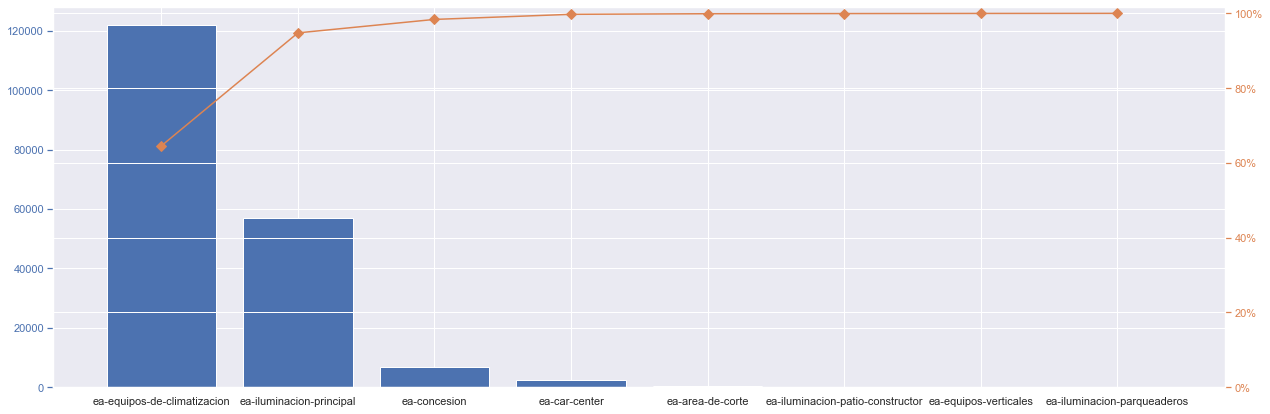

Main variable labels:
[
    "pa-equipos-de-climatizacion",
    "pa-iluminacion-principal"
]


In [23]:
lst_main_labels, hue_order, s_pareto = run_pareto_analysis(df)
plot_pareto(s_pareto)
print("Main variable labels:")
print(json.dumps(lst_main_labels, sort_keys=True, indent=4))

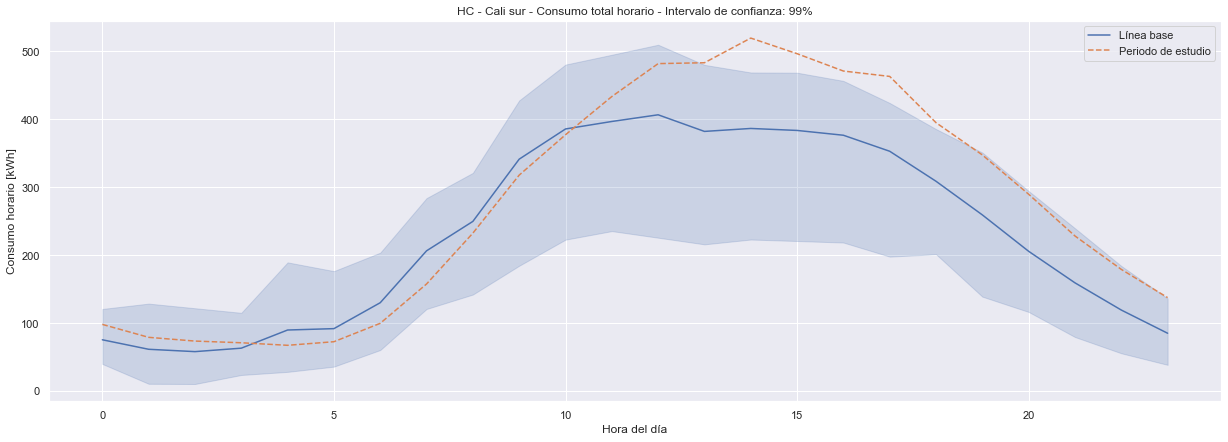

In [24]:
plot_aggregated_hourly_consumption_from_energy(df)

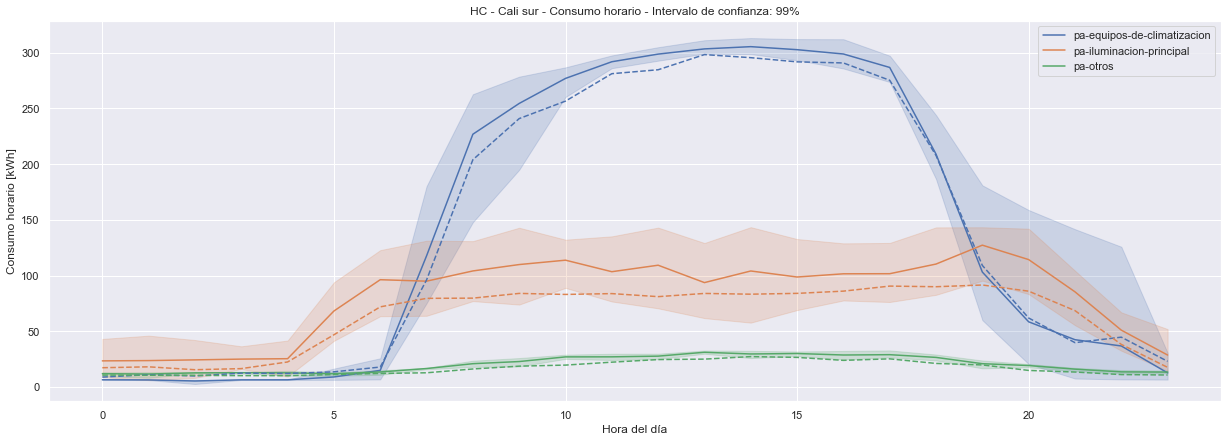

In [25]:
plot_ci_by_hour_single_figure(df, lst_main_labels, hue_order)

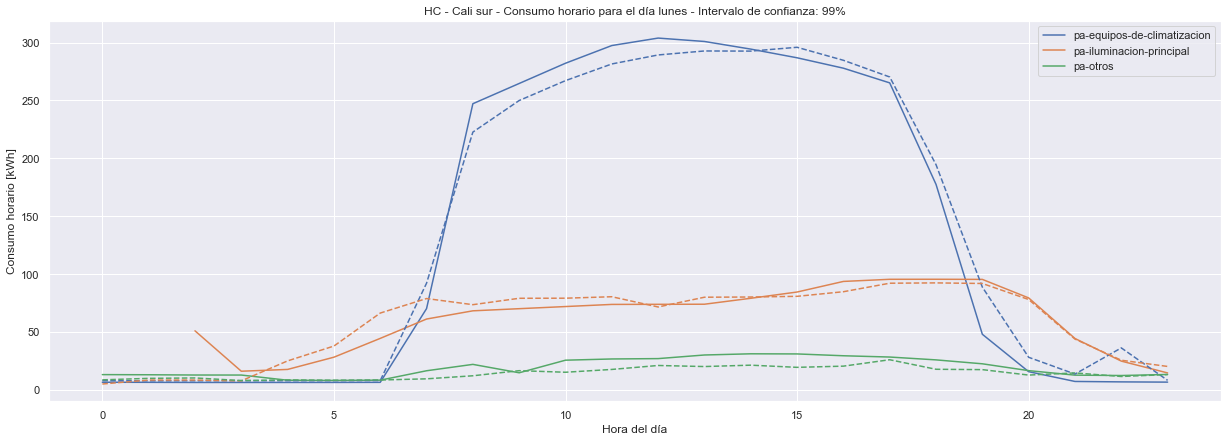

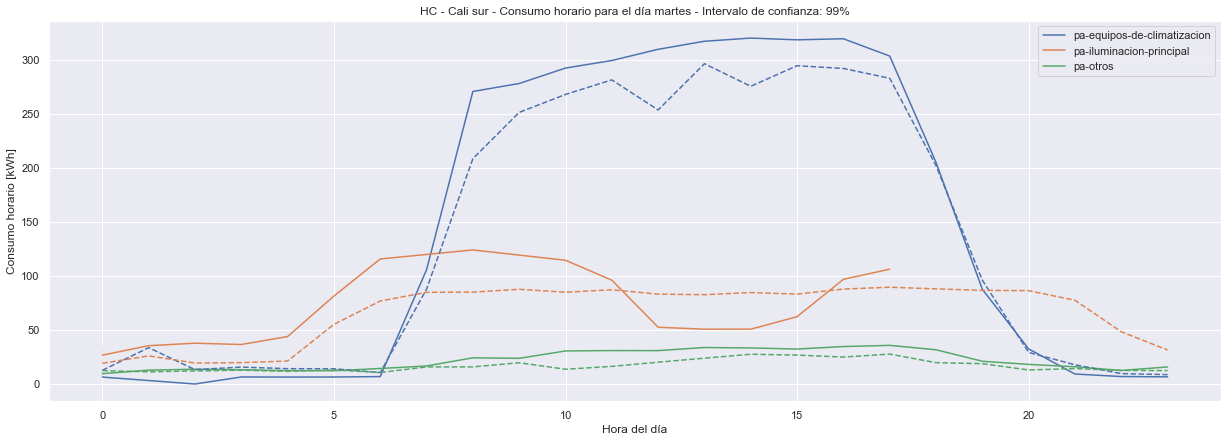

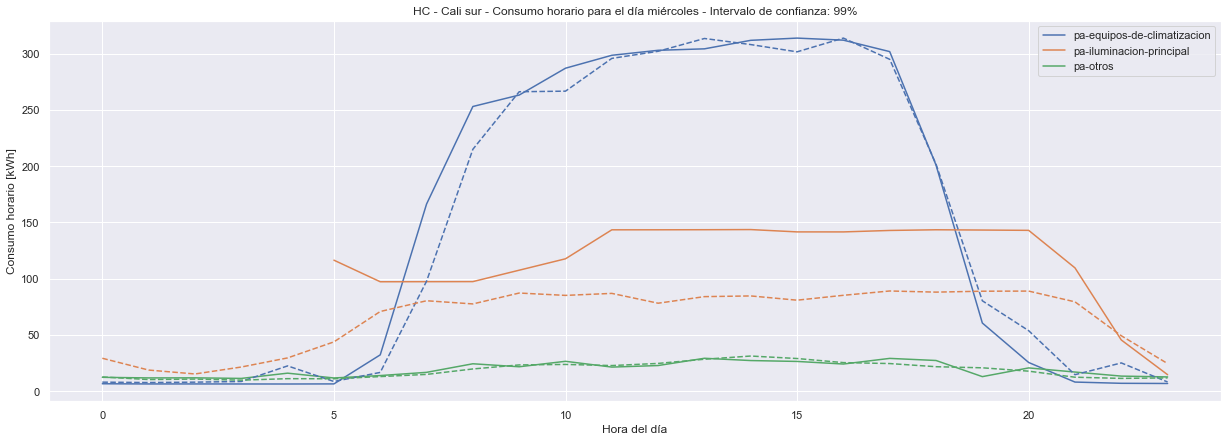

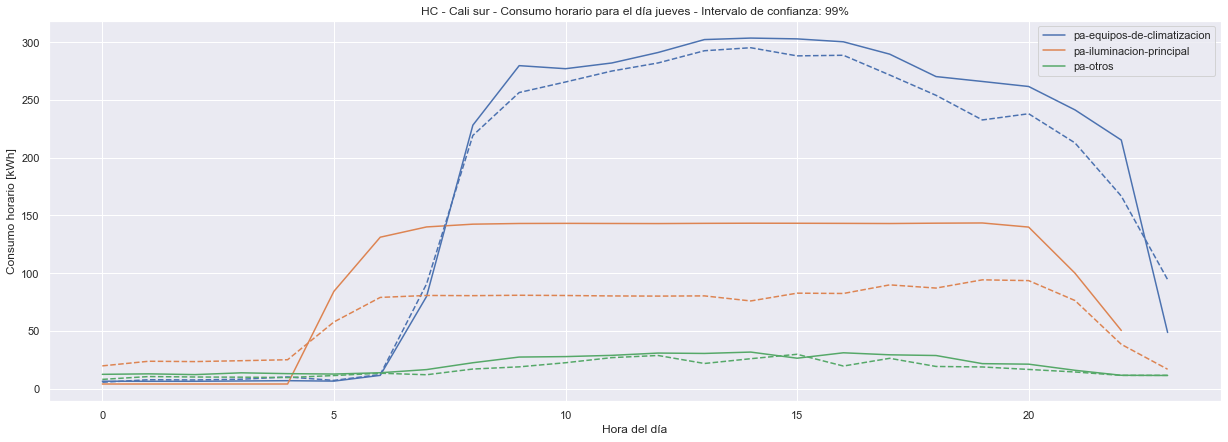

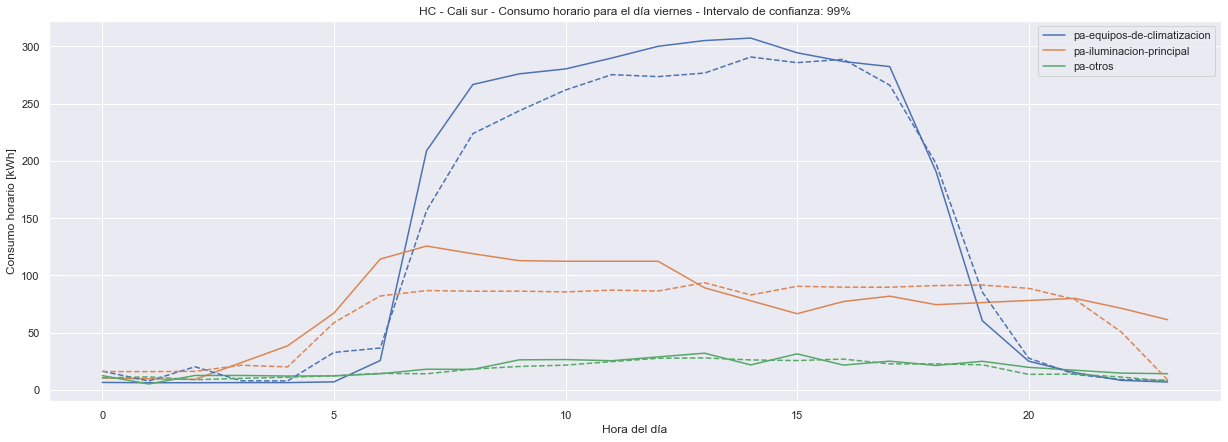

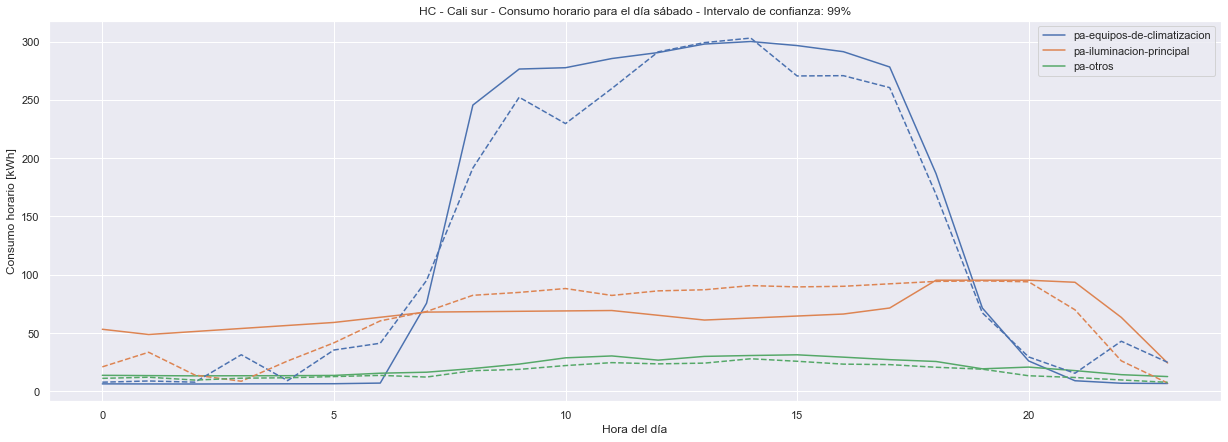

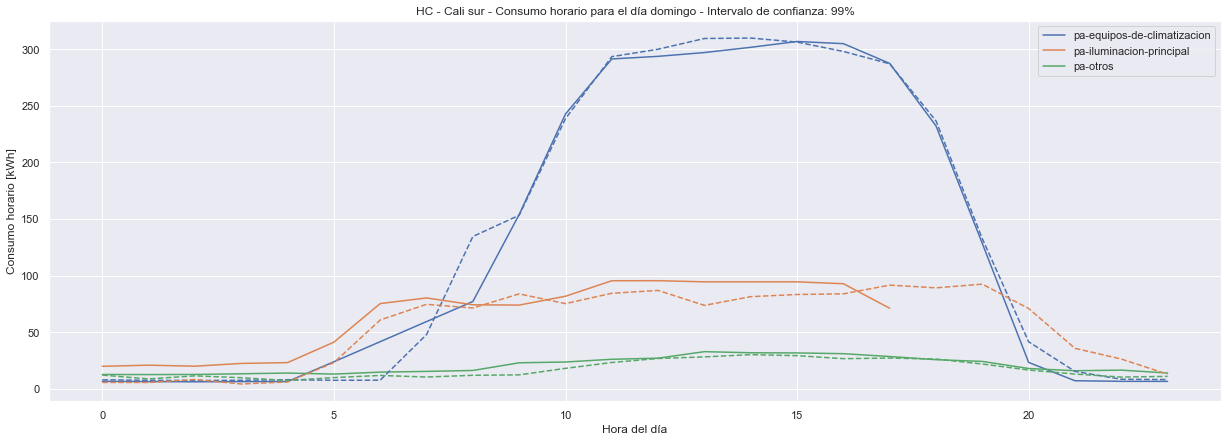

In [26]:
plot_ci_per_dow_multiple_fig_from_power(df, lst_main_labels, hue_order)